<a href="https://colab.research.google.com/github/RohanBolle/BigCrunch/blob/main/Final_Big_Crunch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import scipy as sp
from sympy import lambdify
import cmath
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Secrest's Code

ΣΩ_i = 5.0001   →   Ω_k = -4.0001
Turn-around at a_max = 1.250
Lifetime of the universe:  t_crunch = 1.944  (in 1/H0 units)


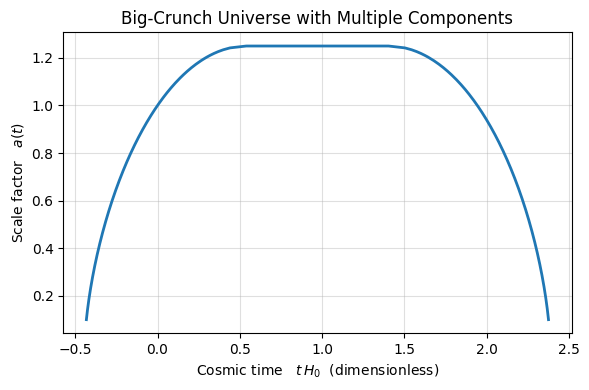

In [18]:
"""
Multi-component Friedmann solver that produces a Big Crunch

Conventions
-----------
c = 1,  a0 = 1  (present-day scale factor)
Time is reported in units of 1/H0  (e.g. 1/H0 ≈ 14 Gyr for H0 = 70 km/s/Mpc)

Components implemented
----------------------
Radiation        :  w = 1/3   (ρ ∝ a⁻⁴)
Matter           :  w = 0     (ρ ∝ a⁻³)
Cosmic strings   :  w = –1/3  (ρ ∝ a⁻²)
Domain walls     :  w = –2/3  (ρ ∝ a⁻¹)
Stiff matter     :  w = 1     (ρ ∝ a⁻⁶)
Dark energy (Λ)  :  w = –1    (ρ ∝ const.; ΩΛ may be *negative*)
Spatial curvature:  encoded through Ω_k = 1 – ΣΩ_i   (positive k ⇒ Ω_k < 0)

A closed (Ω_k < 0) matter-dominated model *or* a model with negative Λ will
recollapse.  By default we combine both so the turnaround happens quickly
enough to see on a small time axis.
"""
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. Specify the energy-density parameters Ω_i at a = 1
#    ***Adjust these to taste, but keep  ΣΩ_i  > 1  OR  choose ΩΛ < 0
# -----------------------------------------------------------------------------
params = {
    "radiation"      : 1.0e-4,   # Ω_r [0.10]
    "matter"         : 5.00,   # Ω_m [1.20]
    "cosmic_strings" : 0.00,   # Ω_cs[0.05]
    "domain_walls"   : 0.00,   # Ω_dw[0.05]
    "stiff_matter"   : 0.00,   # Ω_sm[0.0]
    "dark_energy"    : 0.00   # Ω_Λ [-0.50](NEGATIVE ⇒ acts like an attractive force)
}

# Barotropic indices  w  for the components
w_map = {
    "radiation"      : 1/3,
    "matter"         : 0.0,
    "cosmic_strings" : -1/3,
    "domain_walls"   : -2/3,
    "stiff_matter"   : 1.0,
    "dark_energy"    : -1.0
}

# Present-day curvature parameter Ω_k
Omega_total = sum(params.values())
Omega_k = 1.0 - Omega_total        # closed if Ω_k < 0
print(f"ΣΩ_i = {Omega_total}   →   Ω_k = {Omega_k}")

# -------------------------------------------------------------------------
# 2. Helper: E(a) = H(a) / H0  (dimensionless Hubble parameter)
# -------------------------------------------------------------------------
def E2(a: float) -> float:
    """Dimensionless Hubble parameter squared, E(a)^2."""
    term_sum = Omega_k * a**-2                     # curvature
    for name, Ω in params.items():
        w = w_map[name]
        term_sum += Ω * a**(-3 * (1 + w))
    return term_sum

# -------------------------------------------------------------------------
# 3. Find the turnaround point  a_max  where  E^2 = 0  (expansion stops)
# -------------------------------------------------------------------------
from mpmath import findroot
a_max = float(findroot(lambda x: E2(x), 1.0))      # initial guess 2 ≳ 1
print(f"Turn-around at a_max = {a_max:.3f}")

# -------------------------------------------------------------------------
# 4. Cosmic time t(a) by quadrature  t = ∫ da / [a H0 E(a)]
# -------------------------------------------------------------------------
H0 = 1.0   # we work in units where H0 = 1; multiply by 1/H0 later if needed

def dt_da(a):           # integrand  dt/da  for outward (+) branch
    return 1.0 / (a * np.sqrt(E2(a)))

# Time from today (a=1) to the turnaround
t_half, _ = quad(dt_da, 0.1, a_max, epsabs=1e-9, epsrel=1e-9, limit=200)
t_total = 2.0 * t_half
print(f"Lifetime of the universe:  t_crunch = {t_total:.3f}  (in 1/H0 units)")

# -------------------------------------------------------------------------
# 5. Generate a(t) for plotting: integrate out, then mirror back
# -------------------------------------------------------------------------
a_grid = np.geomspace(0.1, a_max, 400)
t_grid = np.array([quad(dt_da, 1.0, a)[0] for a in a_grid])
# Contracting branch: reverse arrays and shift time by t_half
a_full = np.concatenate([a_grid, a_grid[::-1]])
t_full = np.concatenate([t_grid,  t_half + (t_half - t_grid[::-1])])

# -------------------------------------------------------------------------
# 6. Plot
# -------------------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(t_full, a_full, lw=2)
plt.xlabel(r"Cosmic time   $t\,H_0$  (dimensionless)")
plt.ylabel(r"Scale factor   $a(t)$")
plt.title("Big-Crunch Universe with Multiple Components")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import root_scalar
import scipy.constants as const


G_0 = 1.0
H_0 = 1/13.8
c = 3e8
h_bar = const.h/(2*np.pi)

omega_0 = 5.0
Omega_k = 1.0 - omega_0

In [20]:
# ------------------------STANDARD BIG CRUNCH------------------------

def E1(a):
  term_a = Omega_k / a**2
  term_b = (omega_0) / (a**3 * G_0)
  term_c = (omega_0**2 * H_0**2) / (G_0 * a**6 * 2 * c**2)
  term_d = (omega_0) / (G_0 * c**3 * a**3)
  return term_a + term_b + term_c + term_d

a_vals_1 = np.geomspace(0.1, 20, 1000)
e1_vals = np.array([E1(a) for a in a_vals_1])
sign_changes = np.where(np.diff(np.signbit(e1_vals)))[0]

if len(sign_changes) > 0:
  idx = sign_changes[0]
  bracket = [a_vals_1[idx], a_vals_1[idx + 1]]
  result = root_scalar(lambda x: E1(x), bracket=bracket, method='brentq')
  a_max1 = result.root

  def dt1_da(a):
    return 1.0 / (a * np.sqrt(E1(a)))

alpha_values = [0.001, 0.01, 0.05, 0.1, 1.0]
crunch_results_pos = []

  # Integrate time from early a ~ 1e-5 instead of a = 1
t1_half, _ = quad(dt1_da, 1e-5, a_max1, epsabs=1e-9, epsrel=1e-9, limit=200)
a1_grid = np.geomspace(1e-5, a_max1, 400)
t1_grid = np.array([quad(dt1_da, 1e-5, a)[0] for a in a1_grid])
a1_full = np.concatenate([a1_grid, a1_grid[::-1]])
t1_full = np.concatenate([t1_grid, t1_half + (t1_half - t1_grid[::-1])])
t1_full_gyr = t1_full * 14  # Convert to billions of years
t1_full_p = (t1_full_gyr * 3.154 * 10**-2)/(np.sqrt(h_bar * G_0)/(c**5))


crunch_results_pos.append((t1_full*14, a1_full))

\begin{equation} 1+ αln(a) \end{equation}

/tmp/ipython-input-21-2261661959.py:46: RuntimeWarning: invalid value encountered in sqrt
  def dt_da(a): return 1.0 / (a * np.sqrt(E2(a)))
/tmp/ipython-input-21-2261661959.py:50: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  t_grid = np.array([quad(dt_da, 0.1, a)[0] for a in a_grid])
/tmp/ipython-input-21-2261661959.py:50: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  t_grid = np.array([quad(dt_da, 0.1, a)[0] for a in a_grid])


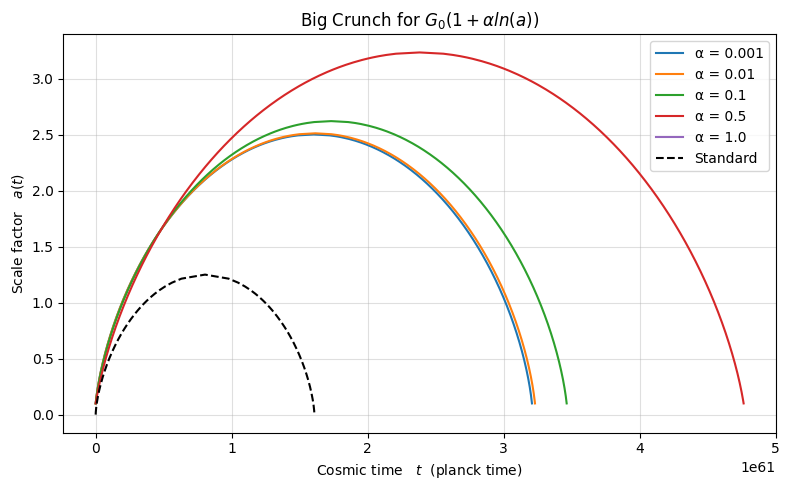

In [21]:
omega_0 = 5.0
Omega_k = 1.0 - omega_0
alpha_values = [0.001, 0.01, 0.1, 0.5, 1.0]
crunch_results_pos = []


#FIXED CODE
def func_0(a, alpha):
    a = float(a)
    return G_0 * alpha * np.log(a) + 2 * G_0

def func_1(a, alpha):
    a = float(a)
    term1 = G_0**2 * (alpha * np.log(a) + 1)**2
    bracket = (G_0**2 * alpha**2 * np.log(a)) / (2 * a**2) - (G_0**2 * alpha**2) / (4 * a**2) + (G_0**2 * alpha) / (2 * a**2)
    term2 = a**2 * bracket
    return term1 - term2

def func_2(a, alpha):
    a = float(a)
    term1 = G_0**2 * (alpha * np.log(a) + 1)**2
    bracket = (G_0**2 * alpha**2 * np.log(a)) / (3 * a**3) - (G_0**2 * alpha**2) / (9 * a**3) + (G_0**2 * alpha) / (3 * a**3)
    term2 = 2 * a**3 * bracket
    return term1 - term2

# -----------------------------x---------------------------------

for alpha in alpha_values:
    def E2(a):
        term0 = Omega_k / a**2
        term1 = (omega_0 * func_0(a, alpha)) / (a**3 * G_0)
        term2 = (omega_0**2 * H_0**2 * func_1(a, alpha)**2) / (G_0 * a**6 * 2 * c**2)
        term3 = (omega_0 * func_2(a, alpha)**2) / (G_0 * c**3 * a**3)
        return term0 + term1 + term2 + term3

    a_vals = np.geomspace(0.1, 20, 1000)
    e2_vals = np.array([E2(a) for a in a_vals])
    sign_changes = np.where(np.diff(np.signbit(e2_vals)))[0]

    if len(sign_changes) > 0:
        idx = sign_changes[0]
        bracket = [a_vals[idx], a_vals[idx + 1]]
        result = root_scalar(lambda x: E2(x), bracket=bracket, method='brentq')
        a_max = result.root

        def dt_da(a): return 1.0 / (a * np.sqrt(E2(a)))

        # Expand from Big Bang (a = 0.1) to a_max
        a_grid = np.geomspace(0.1, a_max, 1000)
        t_grid = np.array([quad(dt_da, 0.1, a)[0] for a in a_grid])
        t_max = t_grid[-1]
        a_full = np.concatenate([a_grid, a_grid[::-1]])
        t_full = np.concatenate([t_grid, t_max + (t_max - t_grid[::-1])])
        t_full_gyr = t_full * 14  # Convert to billions of years

        crunch_results_pos.append((alpha, t_full*14, a_full))

seconds_per_gyr = 3.154e16
t_planck = 5.39e-44
conversion_factor = seconds_per_gyr / t_planck  # Gyr to Planck time

# Plot corrected cosmic time
plt.figure(figsize=(8, 5))
for alpha, t_vals, a_vals in crunch_results_pos:
    t_vals_planck = t_vals * conversion_factor
    plt.plot(t_vals_planck, a_vals, label=f"α = {alpha}")
plt.plot(t1_full_gyr * conversion_factor, a1_full, 'k--', label="Standard")
plt.xlabel(r"Cosmic time   $t$  (planck time)")
plt.ylabel(r"Scale factor   $a(t)$")
plt.title("Big Crunch for $G_{0}(1+\\alpha ln(a))$")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()



\begin{equation} G_{0}a^{B} \end{equation}

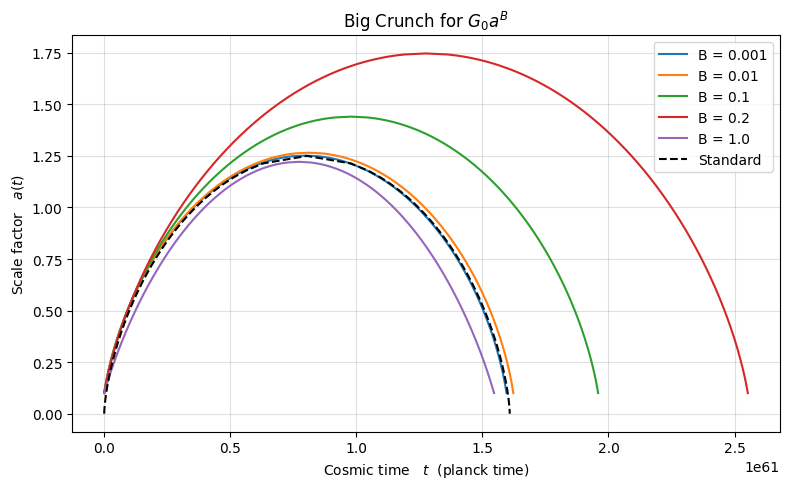

In [24]:
#FIXED CODE
def func1_0(r, B):
    if np.isclose(B, 1):
        return -B * G_0 * r * np.log(r) + G_0 * r**B
    else:
        return -B * G_0 * r * (r**B / (B * r - r)) + G_0 * r**B

def func1_1(r, B):
    if np.isclose(B, 1):
        return B * G_0**2 * r**2 * np.log(r) + G_0**2 * r**(2*B)
    else:
        return B * G_0**2 * r**2 * (r**(2*B) / (2 * B * r**2 - 2 * r**2)) + G_0**2 * r**(2*B)

def func1_2(r, B):
    if np.isclose(B, 1.5):
        return 2 * B * G_0**2 * r**3 * np.log(r) + G_0**2 * r**(2*B)
    else:
        return 2 * B * G_0**2 * r**3 * (r**(2*B) / (2 * B * r**3 - 3 * r**3)) + G_0**2 * r**(2*B)

# -----------------------------x---------------------------------

B_values = [0.001, 0.01, 0.1, 0.2, 1.0]
omega_0 = 5.0
Omega_k = 1.0 - omega_0
crunch_results_pos = []

for B in B_values:
    def E2(a):
        term0 = Omega_k / a**2
        term1 = (omega_0 * func1_0(a, B)) / (a**3 * G_0)
        term2 = (omega_0**2 * H_0**2 * func1_1(a, B)**2) / (G_0 * a**6 * 2 * c**2)
        term3 = (omega_0 * func1_2(a, B)**2) / (G_0 * c**3 * a**3)
        return term0 + term1 + term2 + term3

    a_vals = np.geomspace(0.1, 20, 1000)
    e2_vals = np.array([E2(a) for a in a_vals])
    sign_changes = np.where(np.diff(np.signbit(e2_vals)))[0]

    if len(sign_changes) > 0:
        idx = sign_changes[0]
        bracket = [a_vals[idx], a_vals[idx + 1]]
        result = root_scalar(lambda x: E2(x), bracket=bracket, method='brentq')
        a_max = result.root

        def dt_da(a): return 1.0 / (a * np.sqrt(E2(a)))

        # Integrate time from early a ~ 1e-5 instead of a = 1
        t_half, _ = quad(dt_da, 0.1, a_max, epsabs=1e-9, epsrel=1e-9, limit=200)
        a_grid = np.geomspace(0.1, a_max, 1000)
        t_grid = np.array([quad(dt_da, 0.1, a)[0] for a in a_grid])
        a_full = np.concatenate([a_grid, a_grid[::-1]])
        t_full = np.concatenate([t_grid, t_half + (t_half - t_grid[::-1])])
        t_full_gyr = t_full * 14  # Convert to billions of years

        crunch_results_pos.append((B, t_full*14, a_full))

seconds_per_gyr = 3.154e16
t_planck = 5.39e-44
conversion_factor = seconds_per_gyr / t_planck  # Gyr to Planck time

# Plot corrected cosmic time
plt.figure(figsize=(8, 5))
for B, t_vals, a_vals in crunch_results_pos:
    t_vals_planck = t_vals * conversion_factor
    plt.plot(t_vals_planck, a_vals, label=f"B = {B}")
plt.plot(t1_full_gyr * conversion_factor, a1_full, 'k--', label="Standard")
plt.xlabel(r"Cosmic time   $t$  (planck time)")
plt.ylabel(r"Scale factor   $a(t)$")
plt.title("Big Crunch for $G_{0}a^{B}$")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()